In [1]:
import os
import numpy as np
import sympy as sp
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# from open_atmos_jupyter_utils import show_plot
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic
from tqdm import tqdm

In [56]:
steps_per_iter = 1
opt = Options(n_iters=3, non_zero_mu_coeff=True, infinite_gauge=True, nonoscillatory=True)

In [103]:
nx = 64
ny = 64
x0 = -1.
y0 = -1.
boundary_conditions = (Periodic(), Periodic())

In [104]:
mu = 0.05
c = 1.
min_x, min_y = -1, -1
max_x, max_y = 1, 1
dx = (max_x - min_x) / nx
dy = (max_y - min_y) / ny
solution_symbolic = sp.sympify("sin(pi*(x+y))*exp(-mu*pi**2*t) + 1", rational=True)
solution = solution_symbolic.subs({"mu": mu})

In [105]:
def init_conditions(x, y):
    return solution_symbolic.subs({"t":0, "x": x, "y": y}).evalf()

In [155]:
z = np.array([[init_conditions(x, y) for x in np.linspace(min_x, max_x, nx)] for y in np.linspace(min_y, max_y, ny)], dtype=float).reshape((nx, ny))

In [156]:
advectee = ScalarField(data=z, halo=opt.n_halo, boundary_conditions=boundary_conditions)

In [157]:
# create a vector field for the velocity, 1.5 in x direction and 1 in y direction
field_x = np.full((nx+1, ny), 0.15, dtype=opt.dtype)
field_y = np.full((nx, ny+1), 0.1, dtype=opt.dtype)
advector = VectorField(
    data=(field_x, field_y),
    halo=opt.n_halo,
    boundary_conditions=(boundary_conditions[0], Periodic())
)

In [158]:
stepper = Stepper(options=opt, n_dims=2)

In [159]:
# create a solver
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

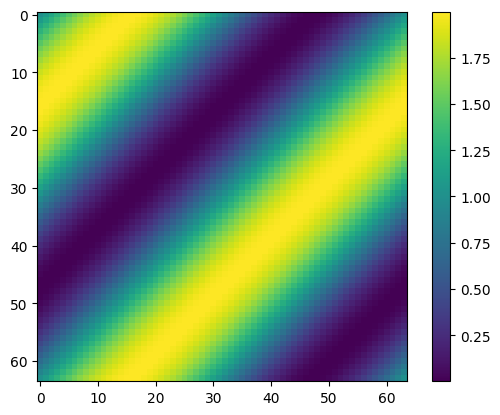

In [160]:
plt.imshow(solver.advectee.get().copy(), cmap='viridis')
plt.colorbar()

In [161]:
states_history = [solver.advectee.get().copy()]
for i in tqdm(range(100)):
    solver.advance(n_steps=10, mu_coeff=(mu, mu))
    states_history.append(solver.advectee.get().copy())


100%|██████████| 100/100 [00:01<00:00, 63.64it/s]


In [162]:
# save each frame as a png to animation2 folder
os.makedirs("animation2", exist_ok=True)
for i, state in enumerate(states_history):
    # flip the image vertically
    state = np.flipud(state)
    plt.imshow(state, cmap='viridis')
    plt.colorbar()
    plt.savefig(f"animation2/frame_{i:03d}.png")
    plt.close()

In [165]:
def get_advection_diffusion_gif(states):
    fig, ax = plt.subplots()
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Advection-Diffusion Equation")
    im = ax.imshow(states[0], cmap='viridis')
    def update(i):
        im.set_array(states[i])
        return im,
    anim = FuncAnimation(fig, update, frames=len(states), blit=True)
    
    anim.save("advection_diffusion.gif", writer='imagemagick', fps=10)

MovieWriter imagemagick unavailable; using Pillow instead.


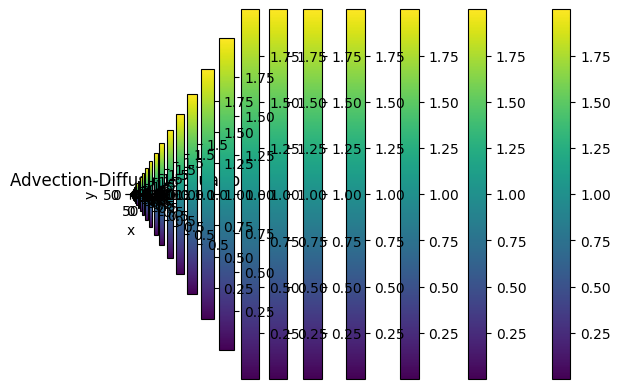

In [166]:
get_advection_diffusion_gif(states_history)